[View in Colaboratory](https://colab.research.google.com/github/3catz/deeplearning_timeseries/blob/master/Interplanetary_Magnetic_Field_Time_Series_Series_Forecasting_with_EEMD_and_Fully_Convolutional_Neural_Networks.ipynb)

#Interplanetary magnetic field EMD time series forecasting with Dilated Convolutional Neural Networks


The interplanetary magnetic field (IMF) is a part of the Sun's magnetic field that is carried into interplanetary space by the solar wind. The IMF is a vector quantity with three directional components, two of which (Bx and By) are oriented parallel to the ecliptic. The time series that I am using here is By component.


Using Ensemble Empirical Mode Decomposition and convolutional neural networks, I created an architecture for forecasting one step ahead based on a lookback of 20 time steps. The predictions for the out of sample set are not recursively defined, but are rather based on the ground-truth of the last 20 time steps. The R2 and explained variances scores are ok, at about 88.6%, though autoML using XGBoost regression got a R2 and explained variance of over 89%. 



In [0]:
!pip install EMD-signal
!pip install auto_ml
!pip install pyhht
from auto_ml import Predictor
#from auto_ml.utils import get_boston_dataset
from auto_ml.utils_models import load_ml_model

from PyEMD import EEMD 
#pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score

import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint
#keras
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.engine.topology import Layer


# Utilities: series to supervised

In [0]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Loading Data 

In [15]:
from google.colab import files    
files.upload()




Saving SPIDR_wind_By.csv to SPIDR_wind_By (1).csv


{'SPIDR_wind_By.csv': b'-5.086,-3.605,-3.444,-2.252,-2.494,-1.978,-3.065,-0.921,-1.454,-1.294,-0.766,-1.945,0.32,1.101,1.908,4.468,2.255,0.348,-0.154,-2.251,-2.793,-3.498,-2.835,-5.149,-5.325,-5.086,-5.09,-4.146,-3.696,-2.642,-3.102,-0.354,0.769,-3.732,-4.625,-4.863,-3.356,-3.138,-1.969,-3.059,-2.777,-2.989,-3.145,-1.691,-1.148,-0.582,-0.69,-0.437,-1.553,-2.683,-2.56,-3.871,-4.51,-3.298,-2.359,-0.283,-3.242,-3.969,-3.448,-0.962,2.712,2.298,2.374,2.587,0.344,1.034,-0.918,-0.961,0.036,1.222,1.913,1.03,0.277,-3.492,-3.307,-1.595,-2.799,-3.465,-3.585,-3.6,-2.627,-1.545,-0.766,0.037,-1.594,-1.924,-2.122,-2.39,-2.158,-1.888,0.551,1.41,1.333,1.531,0.876,0.446,1.499,2.282,3.629,1.416,1.392,1.372,2.641,2.145,0.542,0.347,-0.024,0.005,-2.993,-3.901,-3.516,-3.894,-4.619,-4.982,-3.751,-3.34,-3.974,-4.401,-5.824,-5.956,-5.736,-5.437,-5.408,-4.47,-2.786,3.416,4.823,-0.095,1.845,-0.725,-0.592,0.942,4.001,3.961,3.822,3.198,3.529,3.39,3.654,3.44,2.733,1.491,1.674,2.1,2.1,1.879,2.295,3.963,4.155,3.738,3.

In [0]:
import numpy as np  
data = np.fromfile("lorenz.dat", sep = "\n")

data.shape

In [16]:
import numpy as np
data = np.genfromtxt("SPIDR_wind_By.csv", delimiter = ","); data = np.asarray(data); data.shape

(10000,)

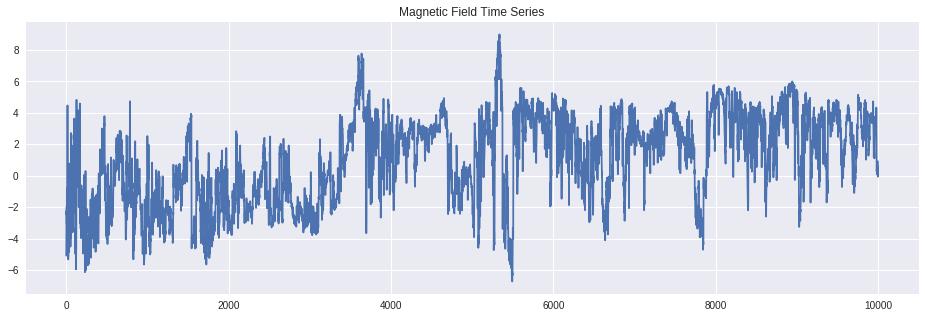

In [18]:
plt.figure(figsize=(16,5))
plt.plot(data)
plt.title("Magnetic Field Time Series")
plt.show()

In [19]:
#Scale the Data
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(10000,)

In [0]:
scaled_data = np.transpose(scaled_data)

In [21]:
# before you do the EMD, cut out the out of sample part so that the EMDs are not constructed with those future values and information contained within them

in_sample = scaled_data[:-1000]; out_sample = scaled_data[-1000:]
print(in_sample.shape)

(9000,)


In [0]:
in_sample = in_sample.reshape(-1,1)

#Empirical Mode Decomposition


In [23]:
eemd = EEMD()
eemd.extrema_detection = "simple"
t = np.linspace(0, in_sample.shape[0], in_sample.shape[0])
t = t.reshape(-1,1)
print(t.shape, in_sample.shape)
t = np.squeeze(t)
in_sample = np.squeeze(in_sample)

(9000, 1) (9000, 1)


In [24]:
imfs1 = eemd(in_sample, t)

print(imfs1.shape)

(16, 9000)


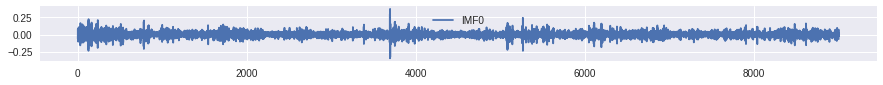

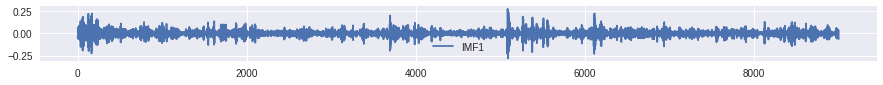

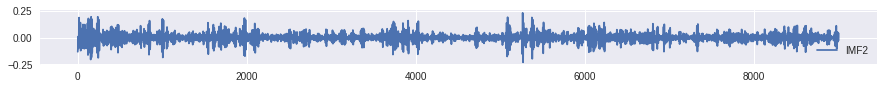

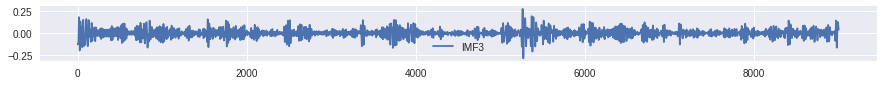

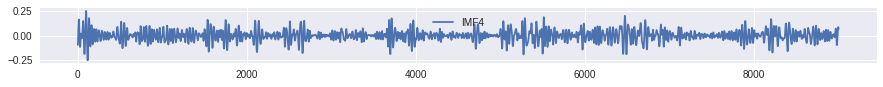

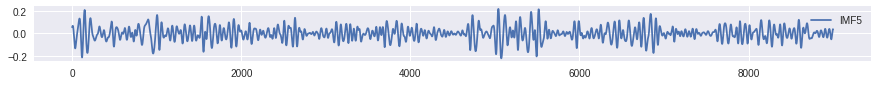

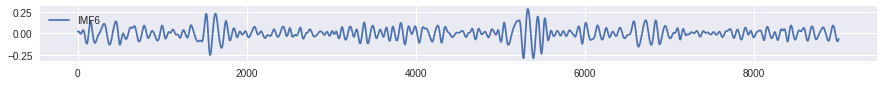

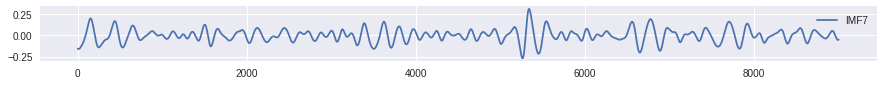

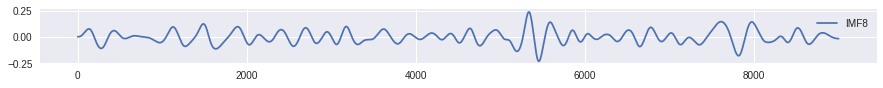

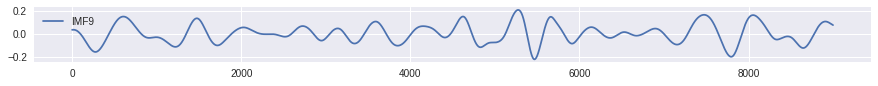

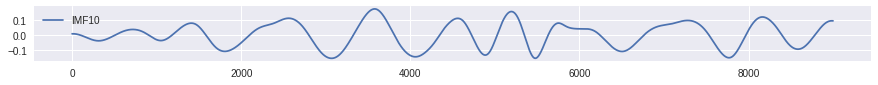

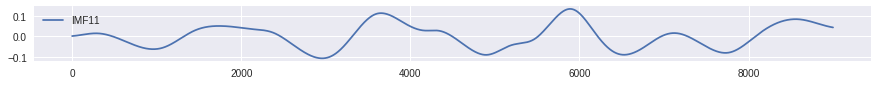

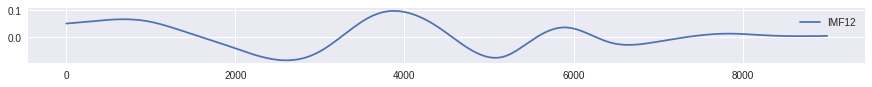

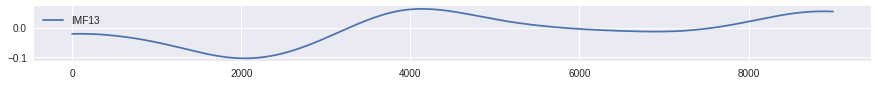

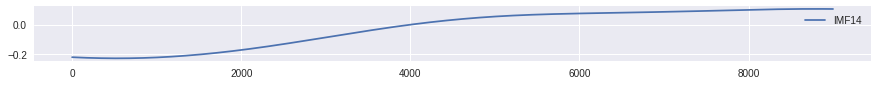

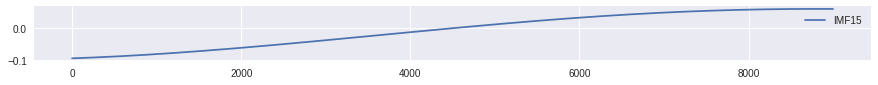

In [25]:
for i in range(len(imfs1)):
  fig, ax = plt.subplots(figsize=(15,1))
  fig = plt.plot(imfs1[i], label = "IMF{}".format(i))
  plt.legend()
  plt.show()

# Creating Datasets


*Raw Data, using lags = 20*

In [26]:
in_sample = in_sample.reshape(-1,1); print(in_sample.shape)

(9000, 1)


In [0]:
from pandas import DataFrame, concat
lookback = 20
data_f = series_to_supervised(in_sample, n_in = lookback, n_out = 1, dropnan = True)

In [28]:
print(data_f.shape)
data_f = np.asarray(data_f)
Xr = data_f[:,:-1]
print(Xr.shape)

(8980, 21)
(8980, 20)


# All IMFs

In [29]:
imfs1.shape
imfs1 = np.transpose(imfs1, (1,0)); 
print(imfs1.shape)
imf_df = series_to_supervised(imfs1, n_in = lookback, n_out = 1, dropnan = True)
imf_df = np.expand_dims(imf_df, axis = 1)
print(imf_df.shape)
imf_df = np.reshape(imf_df, (8980, 21, 16))

print(imf_df.shape)

(9000, 16)
(8980, 1, 336)
(8980, 21, 16)


In [30]:
#so you want imf_df[:,-1,:]
targets = imf_df[:,-1,:]
print(targets.shape)

(8980, 16)


In [31]:
#so reshape everything properly
input_data = np.reshape(Xr, (8980, 1, 20)); input_permuted = np.reshape(Xr,(8980, 20, 1))
targets = np.reshape(targets,(8980, 1, 16))
print(input_data.shape, targets.shape)

(8980, 1, 20) (8980, 1, 16)


In [32]:
#test Y values 

out_df = series_to_supervised(out_sample.reshape(-1,1), n_in = lookback, n_out = 1, dropnan = True)
print(out_df.shape); out_df = np.asarray(out_df)
testX = out_df[:,:-1]; testX = np.expand_dims(testX, axis = 1); print(testX.shape); 
testY = out_df[:,-1]; print(testY.shape)

(980, 21)
(980, 1, 20)
(980,)


# Partial autocorrelation 

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


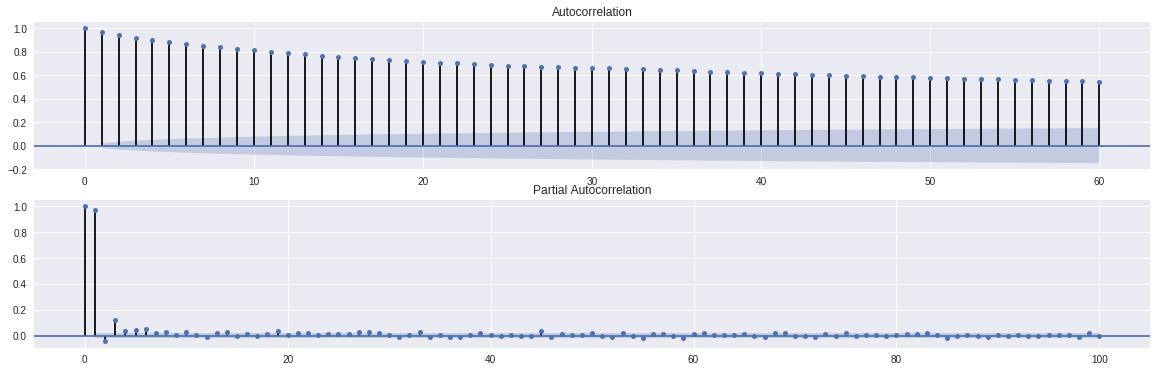

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(2, figsize=(20,6))
fig1 = plot_acf(scaled_data,lags = 60, ax = axes[0])
fig2 = plot_pacf(scaled_data, lags = 100, ax = axes[1])
plt.show()

# Network Architecture and Model fitting 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1, 20)        0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 1, 64)        3904        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 1, 64)        3904        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 1, 64)        3904        input_4[0][0]                    
__________________________________________________________________________________________________
concatenat

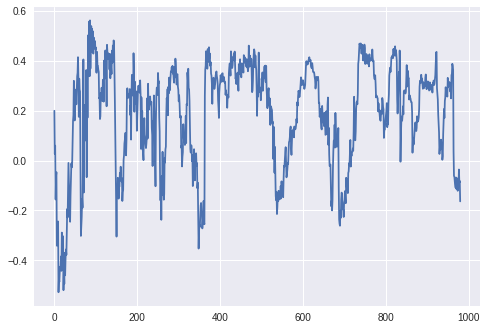

In [45]:
from keras.layers.advanced_activations import *
from keras.regularizers import l1, l2 
from sklearn.metrics import r2_score
import keras.backend as K
from keras.layers import LeakyReLU, Permute, Concatenate, Reshape, Input
from keras import optimizers
import numpy as np
np.random.seed(2018) 
pad = "causal"
inputs = Input(shape = (1, lookback))
enc = inputs 


x0 = Conv1D(64, 3, padding = pad, dilation_rate = 1, 
            activation = "tanh", 
            kernel_initializer = "he_uniform", 
            activity_regularizer = l2(1e-2))(enc)


x1 = Conv1D(64, 3, padding = pad, dilation_rate = 4, 
            activation = "tanh",  
            kernel_initializer = "glorot_uniform", 
            activity_regularizer = l2(1e-2), kernel_regularizer = l2(1e-2))(enc)


x2 = Conv1D(64, 3, padding = pad, dilation_rate = 8, 
            activation = "tanh", 
            kernel_initializer = "glorot_uniform")(enc)



x = concatenate([inputs, x0, x1, x2])

predictions = Conv1D(16,  3, padding = pad, dilation_rate = 2, activation = "tanh", kernel_initializer = "glorot_uniform")(x)

model = Model(inputs = inputs, outputs = predictions)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor = 0.9, patience = 3, min_lr = 1e-5, verbose = 1)
checkpointer = ModelCheckpoint(filepath = "timeseries_weights.hdf5", verbose = 1, save_best_only = True)
early = EarlyStopping(monitor = 'loss', min_delta = 1e-5, patience = 10, verbose = 1)

model.compile(optimizer = optimizers.Adadelta(lr = 1, clipnorm = .05), loss='mse', metrics = [])
model.summary()

history = model.fit(input_data, targets, 
          epochs = 100, 
          batch_size = 128, 
          verbose = 1, 
          #validation_data = (validX, validY),
          callbacks = [reduce_lr, early],
          shuffle = False)  

predictions = model.predict(testX, batch_size = 1)
print(predictions.shape)
summed = np.sum(predictions, axis = -1); print(summed.shape)
test_preds = summed[:,0]
plt.plot(test_preds); print(test_preds.shape) #does this match the testY.shape


Final R2 Score is: 0.8863683281717112
Final Explained Variance Score is: 0.8869238146130908.


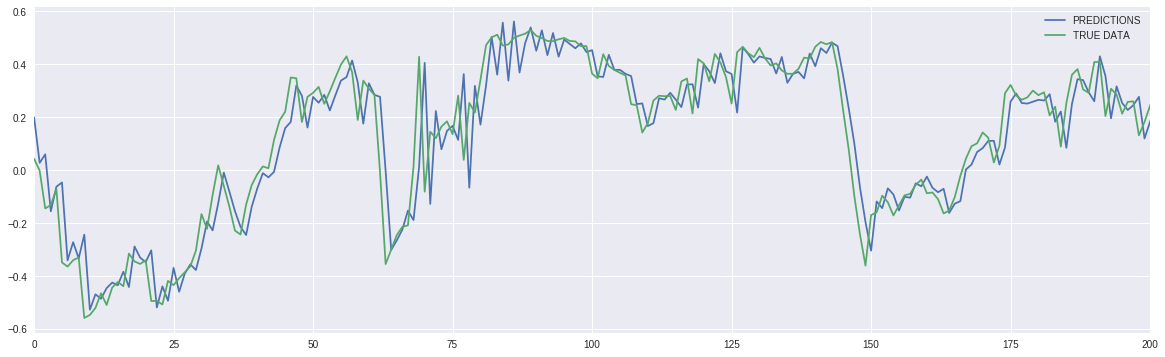

In [47]:
print("Final R2 Score is: {}".format(r2_score(testY, test_preds)))
from sklearn.metrics import explained_variance_score
print("Final Explained Variance Score is: {}.".format(explained_variance_score(testY, test_preds)))
fig = plt.figure(figsize = (20,6))
fig = plt.plot(test_preds, label = "PREDICTIONS")
fig = plt.plot(testY, label = "TRUE DATA")
plt.xlim([0,200])
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()

In [37]:
import pandas as pd
trainX = pd.DataFrame(data_f)
print(trainX)
trainX.columns = trainX.columns.astype(str)
column_descriptions = {"20":"output"}
ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions = column_descriptions)

ml_predictor.train(trainX, model_names=['XGBRegressor'])

            0         1         2         3         4         5         6   \
0    -0.791041 -0.602571 -0.582082 -0.430389 -0.461186 -0.395520 -0.533851   
1    -0.602571 -0.582082 -0.430389 -0.461186 -0.395520 -0.533851 -0.261008   
2    -0.582082 -0.430389 -0.461186 -0.395520 -0.533851 -0.261008 -0.328837   
3    -0.430389 -0.461186 -0.395520 -0.533851 -0.261008 -0.328837 -0.308475   
4    -0.461186 -0.395520 -0.533851 -0.261008 -0.328837 -0.308475 -0.241283   
5    -0.395520 -0.533851 -0.261008 -0.328837 -0.308475 -0.241283 -0.391321   
6    -0.533851 -0.261008 -0.328837 -0.308475 -0.241283 -0.391321 -0.103080   
7    -0.261008 -0.328837 -0.308475 -0.241283 -0.391321 -0.103080 -0.003691   
8    -0.328837 -0.308475 -0.241283 -0.391321 -0.103080 -0.003691  0.099007   
9    -0.308475 -0.241283 -0.391321 -0.103080 -0.003691  0.099007  0.424790   
10   -0.241283 -0.391321 -0.103080 -0.003691  0.099007  0.424790  0.143166   
11   -0.391321 -0.103080 -0.003691  0.099007  0.424790  0.143166

In [38]:
column_descriptions = {"20":"output"}
ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions = column_descriptions)

ml_predictor.train(trainX, model_names=['XGBRegressor'])

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}
Running basic data cleaning
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


********************************************************************************************
About to fit the pipeline for the model XGBRegressor to predict 20
Started at:
2018-09-27 20:26:40
Finished training the pipeline!
Total training time:
0:00:01


Here are the results from our XGBRegressor
predictin

In [0]:
out_df.shape
test_df = pd.DataFrame(out_df)
test_df.columns = test_df.columns.astype(str)


In [40]:
test_score = ml_predictor.score(test_df, test_df["20"])

None


***********************************************
Advanced scoring metrics for the trained regression model on this particular dataset:

Here is the overall RMSE for these predictions:
0.07104012003175324

Here is the average of the predictions:
0.18667769267850992

Here is the average actual value on this validation set:
0.19156247889840616

Here is the median prediction:
0.2495506852865219

Here is the median actual value:
0.257508271824892

Here is the mean absolute error:
0.0459273826219541

Here is the median absolute error (robust to outliers):
0.030299239120401056

Here is the explained variance:
0.8944415126578631

Here is the R-squared value:
0.8939400539789284
Count of positive differences (prediction > actual):
390
Count of negative differences:
590
Average positive difference:
0.05156633906925232
Average negative difference:
-0.04219993683475693


***********************************************


